In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from Levenberg_Marquardt import LevenbergMarquardt

In [2]:
# Read mnist data from the mat file
mnist_data = scipy.io.loadmat("mnist2.mat")
imgs_train = mnist_data['imgs_train']
imgs_test = mnist_data['imgs_test']
labels_train = np.squeeze(mnist_data['labels_train'])
labels_test = np.squeeze(mnist_data['labels_test'])
print(np.shape(imgs_train))
print(np.shape(imgs_test))
print(np.shape(labels_train))
print(np.shape(labels_test))
print(labels_train[:100])
d1,d2,N = np.shape(imgs_train)

(20, 20, 60000)
(20, 20, 10000)
(60000,)
(10000,)
[5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9 4 0 9 1 1 2 4 3 2 7 3 8 6 9 0 5 6
 0 7 6 1 8 7 9 3 9 8 5 9 3 3 0 7 4 9 8 0 9 4 1 4 4 6 0 4 5 6 1 0 0 1 7 1 6
 3 0 2 1 1 7 9 0 2 6 7 8 3 9 0 4 6 7 4 6 8 0 7 8 3 1]


In [3]:
# Select images of 1 and 7
Itrain_1 = np.where(labels_train == 1)
Itrain_7 = np.where(labels_train == 7)
Itest_1 = np.where(labels_test == 1)
Itest_7 = np.where(labels_test == 7)
imgs_train_1 = np.squeeze(imgs_train[:,:,Itrain_1])
imgs_train_7 = np.squeeze(imgs_train[:,:,Itrain_7])
imgs_test_1 = np.squeeze(imgs_test[:,:,Itest_1])
imgs_test_7 = np.squeeze(imgs_test[:,:,Itest_7])
Ntrain_1 = np.size(Itrain_1)
Ntrain_7 = np.size(Itrain_7)
Ntest_1 = np.size(Itest_1)
Ntest_7 = np.size(Itest_7)
print(f"Ntrain_1 = {Ntrain_1}, Ntrain_7 = {Ntrain_7}")
print(f"Ntest_1 = {Ntest_1}, Ntest_7 = {Ntest_7}")

Ntrain_1 = 6742, Ntrain_7 = 6265
Ntest_1 = 1135, Ntest_7 = 1028


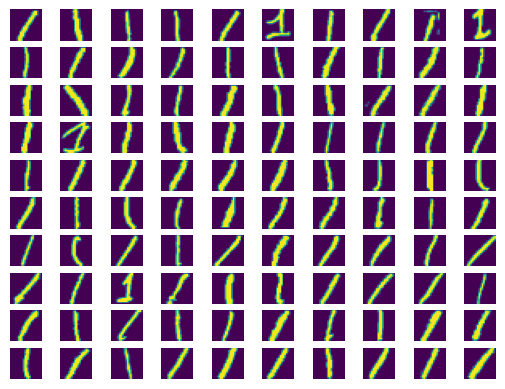

In [4]:
# Dsiplay the first 100 images of 1
m1 = 10
m2 = 10
fig, axs = plt.subplots(m1,m2)
for i in range(m1):
    for j in range(m2):
        img = np.squeeze(imgs_train_1[:,:,i*m2+j])
        axs[i,j].imshow(img)
        axs[i,j].axis("off")       

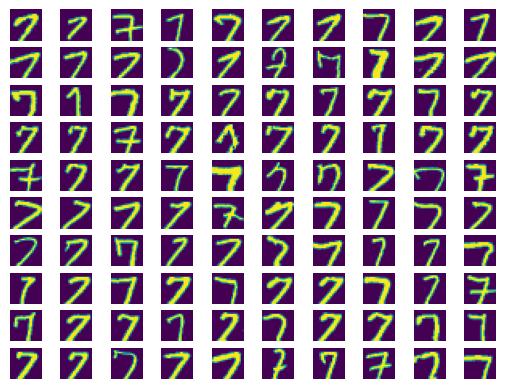

In [5]:
# Dsiplay the first 100 images of 7
m1 = 10
m2 = 10
fig, axs = plt.subplots(m1,m2)
for i in range(m1):
    for j in range(m2):
        img = np.squeeze(imgs_train_7[:,:,i*m2+j])
        axs[i,j].imshow(img)
        axs[i,j].axis("off")       

In [6]:
# Use PCA to reduce the dimensionality to nPCA
NPCA = 20

dd = d1*d2
X1 = np.zeros((Ntrain_1,dd))
X7 = np.zeros((Ntrain_7,dd))
for j in range(Ntrain_1):
    img = np.squeeze(imgs_train_1[:,:,j])
    X1[j,:] = np.reshape(img,(dd,))
for j in range(Ntrain_7):
    img = np.squeeze(imgs_train_7[:,:,j])
    X7[j,:] = np.reshape(img,(dd,))
X = np.concatenate((X1,X7),axis = 0)
print(np.shape(X))
U,S,Vtrans = np.linalg.svd(X,full_matrices = False)
print(f"U: {np.shape(U)}; S: {np.shape(S)}; Vtrans: {np.shape(Vtrans)}")
V = np.transpose(Vtrans)
Xtrain = np.matmul(X,V[:,:NPCA])
print(f"Xtrain: {np.shape(Xtrain)}")

(13007, 400)
U: (13007, 400); S: (400,); Vtrans: (400, 400)
Xtrain: (13007, 20)


/home/daniel/grad/CMSC660/cmsc660-dev/.venv/lib64/python3.11/site-packages/matplotlib/collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


Text(0.5, 0, 'PCA 3')

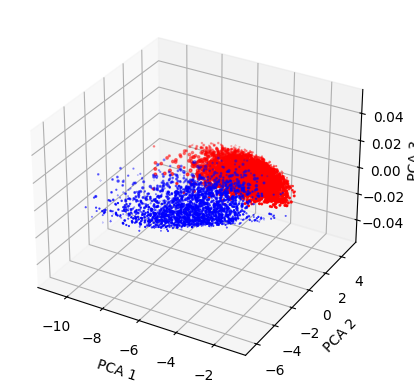

In [7]:
# Plot train data projected onto the first three PCAs
X1_3pca = np.matmul(X1,V[:,:NPCA])
X7_3pca = np.matmul(X7,V[:,:NPCA])
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
# plt.rcParams.update({'font.size': 16})
plt.scatter(X1_3pca[:,0],X1_3pca[:,1],X1_3pca[:,2],color = 'red',label = "1")
plt.scatter(X7_3pca[:,0],X7_3pca[:,1],X7_3pca[:,2],color = 'blue',label = "7")
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')


In [8]:
# Prepare the test set
X1test = np.zeros((Ntest_1,dd))
X7test = np.zeros((Ntest_7,dd))
for j in range(Ntest_1):
    img = np.squeeze(imgs_test_1[:,:,j])
    X1test[j,:] = np.reshape(img,(dd,))
for j in range(Ntest_7):
    img = np.squeeze(imgs_test_7[:,:,j])
    X7test[j,:] = np.reshape(img,(dd,))
Xtest = np.concatenate((X1test,X7test),axis = 0)
Xtest = np.matmul(Xtest,V[:,:NPCA])
print(f"Xtest: {np.shape(Xtest)}")

Xtest: (2163, 20)


In [9]:
# prepare labels for the train and test sets: ones have label 1, sevens have label -1
Ntrain = Ntrain_1 + Ntrain_7
Ntest = Ntest_1 + Ntest_7
lbl_train = np.ones((Ntrain,))
lbl_train[Ntrain_1:] = -1
lbl_test = np.ones((Ntest,))
lbl_test[Ntest_1:] = -1

In [10]:
# Define functions for finding the optimal dividing surface
def logloss_quadratic(X,y,w):
    return 0.5*np.sum((np.log(1. + np.exp(-myquadratic(X,y,w))))**2)

def Res_and_Jac(X,y,w):
    # the vector of residuals r
    aux = np.exp(-myquadratic(X,y,w))
    r = np.log(1. + aux)
    # the Jacobian matrix J[i,j] = dr[i]/dx[j]
    a = -aux/(1. + aux)
    n,d = np.shape(X)
    d2 = d*d
    ya = y*a
    qterm = np.zeros((n,d2))
    for k in range(n):
        xk = X[k,:]
        xx = np.outer(xk,xk)
        qterm[k,:] = np.reshape(xx,(np.size(xx),))
    J = np.concatenate((qterm,X,np.ones((n,1))),axis = 1)   
    for k in range(n):
        J[k,:] = J[k,:]*ya[k]
    return r,J

def myquadratic(X,y,w):
    d = np.size(X,axis = 1)
    d2 = d*d
    W = np.reshape(w[:d2],(d,d))
    v = w[d2:d2+d];
    b = w[-1]
    qterm = np.diag(X@W@np.transpose(X))
    q = y*qterm + (np.outer(y,np.ones((d,)))*X)@v + y*b
    return q

In [15]:
Xtrain.shape

(13007, 20)

In [18]:
lbl_train

array([ 1.,  1.,  1., ..., -1., -1., -1.])

In [11]:
# Call Levenberg-Marquardt
d = NPCA
def r_and_J(w):
    return Res_and_Jac(Xtrain,lbl_train,w)
# The quadratic surface is of the form x^\top W x + v x + b 
# The total number of parameters in W,v,b is d^2 + d + 1
# The initial guess: all parameters are ones
w = np.ones((d*d + d + 1,))
iter_max = 600
tol = 1e-3
w,Niter,Loss_vals,gradnorm_vals = LevenbergMarquardt(r_and_J,w,iter_max,tol)
# print(w)

iter 0: loss =  40020620.17958137  gradnorm =  26687972.46165813
LM, iter #1: loss = 3.4930e+07, gradnorm = 2.4236e+07, rho = 1.0002e+00, R = 4.0000e-01
LM, iter #2: loss = 2.6174e+07, gradnorm = 1.9589e+07, rho = 1.0006e+00, R = 8.0000e-01
LM, iter #3: loss = 1.3807e+07, gradnorm = 1.1744e+07, rho = 1.0108e+00, R = 1.0000e+00
LM, iter #4: loss = 5.7383e+06, gradnorm = 5.3243e+06, rho = 1.0360e+00, R = 1.0000e+00
LM, iter #5: loss = 2.3873e+06, gradnorm = 2.2328e+06, rho = 1.0667e+00, R = 1.0000e+00
LM, iter #6: loss = 1.0050e+06, gradnorm = 9.6176e+05, rho = 1.0829e+00, R = 1.0000e+00
LM, iter #7: loss = 4.2816e+05, gradnorm = 3.8766e+05, rho = 1.0772e+00, R = 1.0000e+00
LM, iter #8: loss = 1.9732e+05, gradnorm = 1.5917e+05, rho = 1.0811e+00, R = 1.0000e+00
LM, iter #9: loss = 9.9127e+04, gradnorm = 6.8705e+04, rho = 1.0532e+00, R = 1.0000e+00
LM, iter #10: loss = 5.3915e+04, gradnorm = 3.2151e+04, rho = 1.0345e+00, R = 1.0000e+00
LM, iter #11: loss = 3.1496e+04, gradnorm = 1.6671e+04

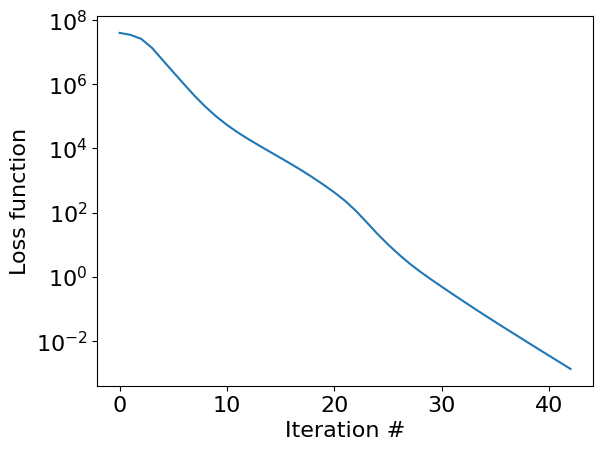

In [16]:
# Plot the loss function 
fig = plt.figure()
plt.rcParams.update({'font.size': 16})
plt.plot(Loss_vals,label = "Loss")
plt.xlabel("Iteration #")
plt.ylabel("Loss function")
plt.yscale("log")

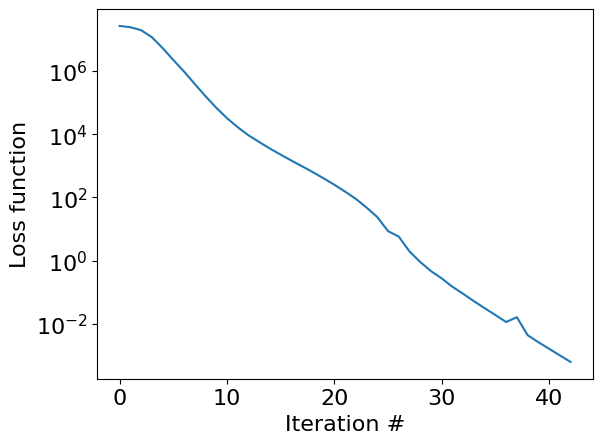

In [13]:
# Plot the norm of the gradient of the loss
fig = plt.figure()
plt.rcParams.update({'font.size': 16})
plt.plot(gradnorm_vals,label = "||grad Loss||")
plt.xlabel("Iteration #")
plt.ylabel("Loss function")
plt.yscale("log")

In [17]:
# Apply the learned classifier to the test set
test0 = myquadratic(Xtrain,lbl_train,w)
hits = np.argwhere(test0 > 0)
misses = np.argwhere(test0 < 0)
Nhits0 = np.size(hits)
Nmisses0 = np.size(misses)
print(f"TRAIN SET: {Nhits0} are classified correctly, {Nmisses0} are misclassified")

test = myquadratic(Xtest,lbl_test,w)
hits = np.argwhere(test > 0)
misses = np.argwhere(test < 0)
Nhits = np.size(hits)
Nmisses = np.size(misses)
print(f"TEST SET: {Nhits} are classified correctly, {Nmisses} are misclassified")
misses = np.squeeze(misses)
print("Misses in the test set: ",misses)

TRAIN SET: 13007 are classified correctly, 0 are misclassified
TEST SET: 2152 are classified correctly, 11 are misclassified
Misses in the test set:  [  83  441  907 1187 1203 1264 1285 1409 1533 1543 1620]


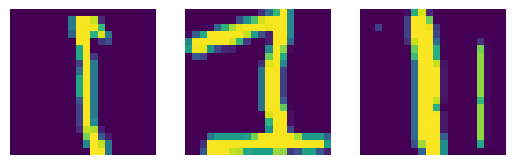

In [37]:
# display misclassified ones in the test set
error1 = np.argwhere(misses < Ntest_1)
N1 = np.size(error1)
fig, axs = plt.subplots(1,N1)
for k in range(N1):   
    img = np.squeeze(imgs_test_1[:,:,misses[k]])
    axs[k].imshow(img)
    axs[k].axis("off")   

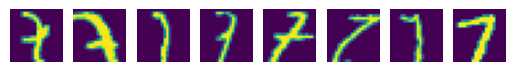

In [39]:
# display misclassified sevens in the test set
error7 = np.argwhere(misses >= Ntest_1)
N7 = np.size(error7)
fig, axs = plt.subplots(1,N7)
for k in range(N7):
    img = np.squeeze(imgs_test_7[:,:,misses[k+N1]-Ntest_1])
    axs[k].imshow(img)
    axs[k].axis("off")   